<a href="https://colab.research.google.com/github/anonyms/Kaggle_HousePricesAdvancedRegressionTechniques/blob/master/Kaggle_House_Prices_Advanced_Regression_Techniques_Blend_%26_Stack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd
from datetime import datetime

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from google.colab import files
seed = 4

Preparing folders

In [0]:
housing_data_loctaion = "~/data/housing/"
submission_file_name = "submissions.csv"
submission_file_location = housing_data_loctaion + submission_file_name
!mkdir ~/data

Kaggle Set-up

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anoynms","key":"4b2c6afaefabfef48178035ff45d414b"}'}

In [4]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques -p $housing_data_loctaion

  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 10.9MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 61.3MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 59.9MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 29.3MB/s]


Read data

In [0]:
train = pd.read_csv(housing_data_loctaion + "train.csv")
test = pd.read_csv(housing_data_loctaion + "test.csv")
train.drop(["Id"],axis=1,inplace=True)
test.drop(["Id"],axis=1,inplace=True)

Stupid Simple Eval functions - for my own testing's sake

In [0]:
def eval_predictions(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return(rmse)
def eval_predictions_mean(actual, predicted):
    rel_error = []
    for i in actual:
      diff = abs(actual-predicted)/actual
      rel_error.append(diff)
    rel_error_arry = np.array(rel_error)
    return(rel_error_arry.mean())

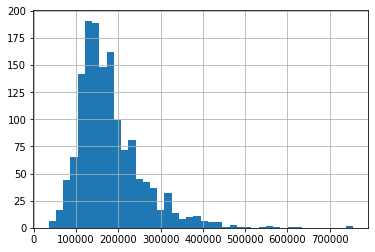

In [18]:
train['SalePrice'].hist(bins=42)

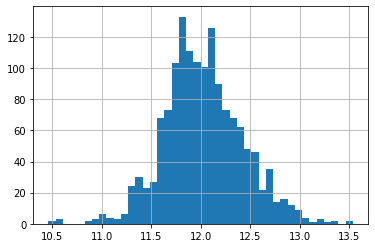

In [19]:
np.log1p(train['SalePrice']).hist(bins=42)

Data Processing

In [0]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'],axis=1)
features = pd.concat([train_features, test]).reset_index(drop=True)


In [0]:
label_name = 'SalePrice'
## Picked the features bellow following EDA
train['YearsBetween'] = train['YrSold']-train['YearBuilt']
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["GarageArea"] = features["GarageArea"].fillna(0)
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [69]:
label_name = 'SalePrice'
## Picked the features bellow following EDA
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["GarageArea"] = features["GarageArea"].fillna(0)
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))
skew_features = features[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
for i in skew_index:
  features[i] = boxcox1p(features[i],boxcox_normmax(features[i]+1))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


Feature Engineering

In [70]:
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['YearsBetween'] = features['YrSold']-features['YearBuilt']
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 314)

In [0]:
picked_features = ['OverallCond', 'YearsBetween','OverallQual',
            'GrLivArea', '2ndFlrSF','LotArea','TotalBsmtSF','GarageArea','haspool','hasgarage','hasfireplace','hasbsmt','has2ndfloor',
            'FullBath','YearRemodAdd','Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide', 'Neighborhood_ClearCr',
            'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL','MSZoning_RM',
            'Total_Bathrooms','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV',
            'KitchenQual_Ex', 'KitchenQual_Fa','KitchenQual_Gd', 'KitchenQual_TA',
            'Neighborhood_Mitchel','Neighborhood_NAmes','Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
            'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr','Neighborhood_Timber','Neighborhood_Veenker']

In [72]:
final_features = final_features[picked_features]
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 50), (1458,), (1459, 50))

In [73]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])
X.shape, y.shape, X_sub.shape

((1453, 50), (1453,), (1459, 50))

In [0]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [0]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)     
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)                   

In [0]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [77]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[19:43:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
[19:44:46] WARNING: /workspace/src/obje

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


lightgbm


In [0]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [85]:
test_precitions = blend_models_predict(X)
print(eval_predictions(np.expm1(y), np.expm1(test_precitions)))
print(eval_predictions_mean(np.expm1(y), np.expm1(test_precitions)))

14207.961104444885
0.05473857657685918


Predict new data using model & Format predictions

In [0]:
# Predict
predictions = np.expm1(blend_models_predict(X_sub))


submission = pd.read_csv(housing_data_loctaion + "sample_submission.csv")
submission.iloc[:,1] = predictions
# Format for submission
##submission_data = pd.DataFrame({'Id': competition_unseen_data_no_labels.Id, label_name: predictions})

Check submission

# Submitting

In [89]:
submission.head()

,Id,SalePrice
0,1461,124081.681630
1,1462,154404.151096
2,1463,177470.539094
3,1464,189351.499330
4,1465,187430.945049


In [0]:
submission.to_csv(submission_file_location, index=False)

Verify submission file

In [92]:
!head $submission_file_location

Id,SalePrice
1461,124081.68162986478
1462,154404.15109582708
1463,177470.53909374072
1464,189351.4993301263
1465,187430.9450488311
1466,176806.83856888895
1467,174366.8754398707
1468,169662.24986538998
1469,188651.766949222


Submit submitt submitus

In [93]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f $submission_file_location -m "Ensemble - Blend & Stack"

100% 33.7k/33.7k [00:01<00:00, 18.0kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques